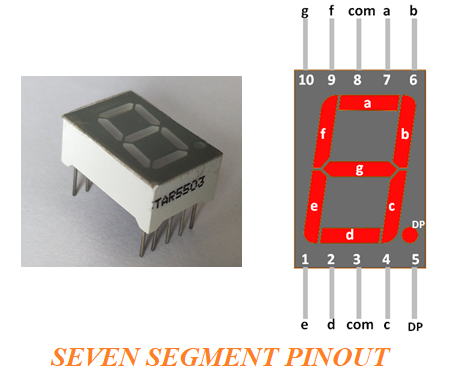

In [ ]:
#logica 
# la idea es poner las siguientes reglas
# primero el valor se pasa a binario
# el valor maximo es 1001 que representa a 9 en binario

#mapeo de la salida
# n -> xyzw -> a | b | c | d | e | f | g 
# 0 -> 0000 -> 1 | 1 | 1 | 1 | 1 | 1 | 0 
# 1 -> 0001 -> 0 | 1 | 1 | 0 | 0 | 0 | 0 
# 2 -> 0010 -> 1 | 1 | 0 | 1 | 1 | 0 | 1 
# 3 -> 0011 -> 1 | 1 | 1 | 1 | 0 | 0 | 1 
# 4 -> 0100 -> 0 | 1 | 1 | 0 | 0 | 1 | 1  
# 5 -> 0101 -> 1 | 0 | 1 | 1 | 0 | 1 | 1  
# 6 -> 0110 -> 1 | 0 | 1 | 1 | 1 | 1 | 1  
# 7 -> 0111 -> 1 | 1 | 1 | 0 | 0 | 0 | 0  
# 8 -> 1000 -> 1 | 1 | 1 | 1 | 1 | 1 | 1  
# 9 -> 1001 -> 1 | 1 | 1 | 0 | 0 | 1 | 1  

#separar numero en variables 
#n se divide en 4 variables x,y,z,w
# ahora la idea es tener entradas binarias conectarlas a las salidas

#la idea es que 4 señales de bit (x,y,z,w) producen 7 salidas (a, . . . ,g)

# representamos el low y high con un boleano

# entonces diagramamos la logica por cada segmento


In [1]:
# logic.py
def seven_segment_logic(n, active_low=False):
    """
    Devuelve un dict con las salidas a..g como bool (True = ON) para dígitos 0..9.
    Si active_low=True devuelve la versión invertida (0 = ON) útil para chips como 7447.
    """
    if not isinstance(n, int) or n < 0 or n > 9:
        raise ValueError("n debe ser entero entre 0 y 9")

    # Mapping estándar (a,b,c,d,e,f,g) -> 1 = segmento ON
    mapping = {
        0: [1,1,1,1,1,1,0],
        1: [0,1,1,0,0,0,0],
        2: [1,1,0,1,1,0,1],
        3: [1,1,1,1,0,0,1],
        4: [0,1,1,0,0,1,1],
        5: [1,0,1,1,0,1,1],
        6: [1,0,1,1,1,1,1],
        7: [1,1,1,0,0,0,0],
        8: [1,1,1,1,1,1,1],
        9: [1,1,1,1,0,1,1],
    }

    bits = mapping[n]
    segs = dict(zip(["a","b","c","d","e","f","g"], [bool(b) for b in bits]))

    if active_low:
        # invertir para outputs activas en 0 (LOW)
        segs = {k: not v for k, v in segs.items()}

    return segs


In [2]:
# main.py
import sys
from PyQt5.QtWidgets import QApplication, QWidget, QLineEdit, QVBoxLayout, QLabel, QPushButton, QHBoxLayout
from PyQt5.QtGui import QPainter, QBrush, QColor, QFont
from PyQt5.QtCore import Qt
#from logic import seven_segment_logic

class SevenSegmentWidget(QWidget):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("7-Segment (logic externalizada)")
        self.setGeometry(200, 200, 320, 420)

        layout = QVBoxLayout()
        top = QHBoxLayout()
        self.input = QLineEdit()
        self.input.setPlaceholderText("Ingresa número 0-9 y presiona Enter")
        self.input.returnPressed.connect(self.on_enter)
        top.addWidget(self.input)

        self.test_btn = QPushButton("Test 0..9")
        self.test_btn.clicked.connect(self.test_all)
        top.addWidget(self.test_btn)

        layout.addLayout(top)

        self.bin_label = QLabel("bits: ----")
        layout.addWidget(self.bin_label)

        self.setLayout(layout)

        # inicialmente todo apagado
        self.segments = {s: False for s in "abcdefg"}
        self.current = None  # dígito actual

    def on_enter(self):
        try:
            n = int(self.input.text())
            if n < 0 or n > 9:
                self.bin_label.setText("Ingresa 0..9")
                return
            # aquí pedimos la lógica desde logic.py
            self.segments = seven_segment_logic(n, active_low=False)
            self.current = n
            bstr = format(n, "04b")
            self.bin_label.setText(f"bits: {bstr}  (x,y,z,w)")
            # debug: imprimir en consola las salidas
            print(f"Digit {n} -> segments: {self.segments}")
            self.update()
        except Exception as e:
            self.bin_label.setText("Error: " + str(e))

    def test_all(self):
        # recorre 0..9 con pausas cortas
        # para simplicidad actualiza instantáneamente el último valor
        for n in range(10):
            self.input.setText(str(n))
            self.on_enter()
            QApplication.processEvents()

    def paintEvent(self, event):
        painter = QPainter(self)
        painter.setRenderHint(QPainter.Antialiasing)

        # parámetros adaptables
        ox = 40
        oy = 40
        seg_len = 120
        seg_th = 20
        # colores
        on_color = QColor(220, 40, 40)
        off_color = QColor(80, 80, 80)

        # coordenadas calculadas
        coords = {
            "a": (ox + seg_th, oy, seg_len, seg_th),
            "b": (ox + seg_th + seg_len, oy + seg_th, seg_th, seg_len),
            "c": (ox + seg_th + seg_len, oy + 2*seg_th + seg_len, seg_th, seg_len),
            "d": (ox + seg_th, oy + 2*seg_th + 2*seg_len, seg_len, seg_th),
            "e": (ox, oy + 2*seg_th + seg_len, seg_th, seg_len),
            "f": (ox, oy + seg_th, seg_th, seg_len),
            "g": (ox + seg_th, oy + seg_th + seg_len, seg_len, seg_th),
        }

        radius = seg_th // 2  # para bordes redondeados

        for seg, (x, y, w, h) in coords.items():
            brush = QBrush(on_color if self.segments.get(seg, False) else off_color)
            painter.setBrush(brush)
            painter.setPen(Qt.NoPen)
            # dibujo con bordes redondeados (parece "pill")
            painter.drawRoundedRect(x, y, w, h, radius, radius)

        # mostrar dígito grande debajo
        painter.setPen(Qt.black)
        painter.setFont(QFont("Arial", 18))
        if self.current is not None:
            painter.drawText(40, 370, f"Dígito: {self.current}")

if __name__ == "__main__":
    app = QApplication(sys.argv)
    win = SevenSegmentWidget()
    win.show()
    sys.exit(app.exec_())


Digit 1 -> segments: {'a': False, 'b': True, 'c': True, 'd': False, 'e': False, 'f': False, 'g': False}
Digit 2 -> segments: {'a': True, 'b': True, 'c': False, 'd': True, 'e': True, 'f': False, 'g': True}
Digit 4 -> segments: {'a': False, 'b': True, 'c': True, 'd': False, 'e': False, 'f': True, 'g': True}
Digit 6 -> segments: {'a': True, 'b': False, 'c': True, 'd': True, 'e': True, 'f': True, 'g': True}
Digit 0 -> segments: {'a': True, 'b': True, 'c': True, 'd': True, 'e': True, 'f': True, 'g': False}


SystemExit: 0

C:\Users\ivany\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Ahora 

In [4]:
!pip install deap

In [ ]:
import operator, random
from deap import base, creator, gp, tools, algorithms

# ---------------------
# 1. Tabla de verdad 7 segmentos
# ---------------------
seven_seg_map = {
    0:[1,1,1,1,1,1,0],
    1:[0,1,1,0,0,0,0],
    2:[1,1,0,1,1,0,1],
    3:[1,1,1,1,0,0,1],
    4:[0,1,1,0,0,1,1],
    5:[1,0,1,1,0,1,1],
    6:[1,0,1,1,1,1,1],
    7:[1,1,1,0,0,0,0],
    8:[1,1,1,1,1,1,1],
    9:[1,1,1,1,0,1,1],
}

# ---------------------
# 2. Definición de funciones y terminales
# ---------------------
pset = gp.PrimitiveSet("MAIN", 4)  # W,Z,Y,X
pset.renameArguments(ARG0="W")
pset.renameArguments(ARG1="Z")
pset.renameArguments(ARG2="Y")
pset.renameArguments(ARG3="X")

# Funciones lógicas
pset.addPrimitive(lambda a,b: a and b, 2, name="AND")
pset.addPrimitive(lambda a,b: a or b, 2, name="OR")
pset.addPrimitive(lambda a: not a, 1, name="NOT")
pset.addPrimitive(lambda a,b: a ^ b, 2, name="XOR")

# Terminales
pset.addTerminal(True)
pset.addTerminal(False)

# ---------------------
# 3. Tipos y operadores
# ---------------------
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# ---------------------
# 4. Función de aptitud
# ---------------------
def evalCircuit(ind):
    func = toolbox.compile(expr=ind)
    error = 0
    for n in range(10):
        # Entradas binarias W,Z,Y,X
        bits = [bool(int(b)) for b in format(n, '04b')]
        outputs = [func(*bits)]*7  # un árbol único para todas las salidas
        desired = seven_seg_map[n]
        error += sum(int(o != bool(d)) for o,d in zip(outputs, desired))
    return 1/(1+error),

toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalCircuit)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=len, max_value=20))
toolbox.decorate("mutate", gp.staticLimit(key=len, max_value=20))

# ---------------------
# 5. Ejecución
# ---------------------
random.seed(42)
pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)

algorithms.eaSimple(pop, toolbox, 0.7, 0.2, 40, halloffame=hof, verbose=True)

print("Mejor circuito encontrado:", hof[0])


c:\Users\ivany\miniconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\ivany\miniconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	100   
1  	65    
2  	74    
3  	77    
4  	78    
5  	72    
6  	77    
7  	80    
8  	85    
9  	77    
10 	79    
11 	66    
12 	73    
13 	85    
14 	73    
15 	79    
16 	82    
17 	79    
18 	81    
19 	75    
20 	76    
21 	77    
22 	81    
23 	79    
24 	78    
25 	79    
26 	80    
27 	84    
28 	71    
29 	71    
30 	71    
31 	79    
32 	75    
33 	66    
34 	81    
35 	88    
36 	83    
37 	79    
38 	78    
39 	79    
40 	67    
Mejor circuito encontrado: XOR(NOT(W), XOR(W, AND(XOR(XOR(True, Z), XOR(Y, W)), X)))


: 